In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from torch import nn, optim

import torch.nn.functional as F

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataframe

In [3]:
df = pd.read_csv('data/TimeSeries.csv')
labels = pd.read_csv('data/labelsTimeSeries.csv')

In [4]:
df = df.join(labels)
df['label'].value_counts()

0    509189
1       443
Name: label, dtype: int64

In [5]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,label
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95,0
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,0
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,0
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,0
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95,0


### Data preprocessing

In [6]:
normal_df = df[df.label == 0]
anomaly_df = df[df.label == 1]

normal_df.drop(['label'], axis=1, inplace=True)
anomaly_df.drop(['label'], axis=1, inplace=True)

normal_df.reset_index(inplace=True, drop=True)
anomaly_df.reset_index(inplace=True, drop=True)

In [7]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [8]:
def create_dataset(df):

  dataset = []

  sequences = df.astype(np.float32).to_numpy().tolist()

  for ind, seq in enumerate(sequences):
    if ind+2 > len(sequences)-1:
      break

    double_seq = sequences[ind] + sequences[ind+1]

    triple_seq = double_seq + sequences[ind+2]

    triple_seq = torch.tensor(triple_seq).unsqueeze(1).float()

    dataset.append(triple_seq)

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [9]:
train_dataset, seq_len, n_features = create_dataset(train_df[:8800])
val_dataset, _, _ = create_dataset(val_df[:4400])
test_normal_dataset, _, _ = create_dataset(test_df[:2200])
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [10]:
seq_len, n_features

(33, 1)

### Anomaly data augmentation

In [11]:
print("Normal test dataset has {0} examples, anomaly dataset has only {1} examples.".format(len(test_normal_dataset), len(test_anomaly_dataset)))

Normal test dataset has 2198 examples, anomaly dataset has only 441 examples.


In [12]:
test_seq = test_anomaly_dataset[0]

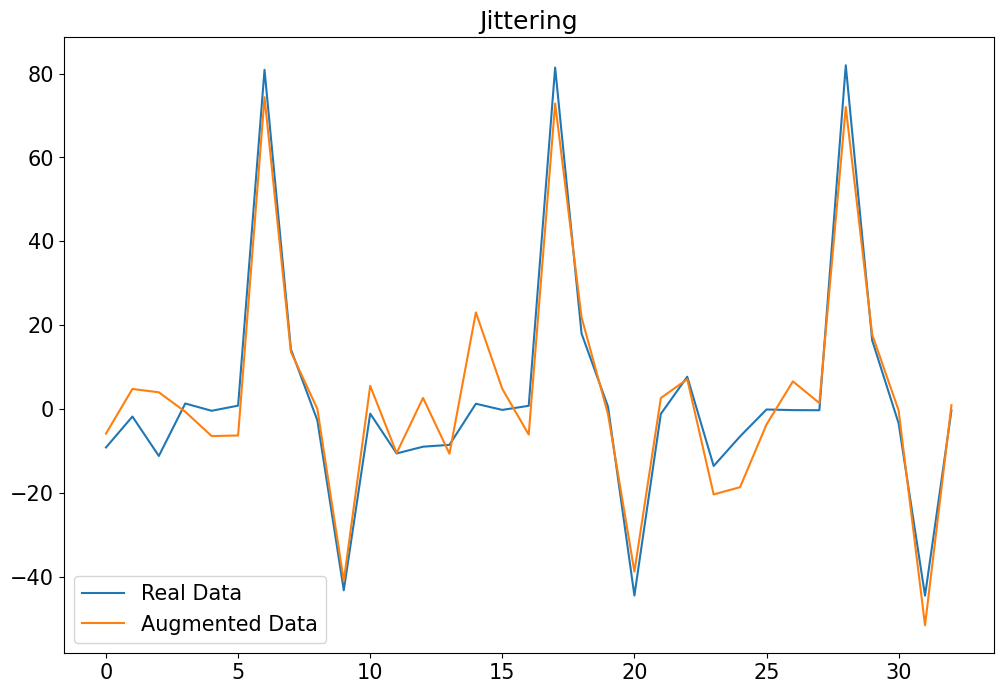

In [18]:
def jitter(input_seq, sigma=8):
    ret = input_seq + np.random.normal(loc=0., scale=sigma, size=input_seq.shape)
    return ret

plt.rcParams['figure.figsize']=[12,8]

plt.plot(test_seq, label='Real Data')
plt.plot(jitter(test_seq), label='Augmented Data')
plt.title('Jittering')
plt.legend(loc='best')
plt.show()

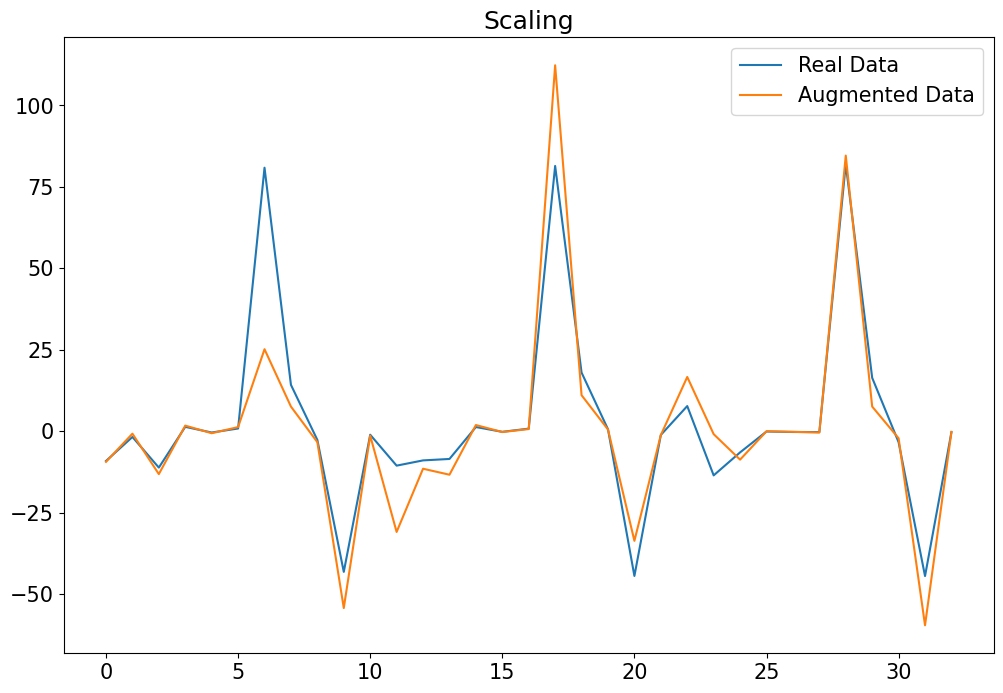

In [19]:
def scaling(input_seq):
  factor = np.random.normal(loc=1., scale=0.5, size=(input_seq.shape[0],input_seq.shape[1]))
  return np.multiply(input_seq, factor)

plt.plot(test_seq, label='Real Data')
plt.plot(scaling(test_seq), label='Augmented Data')
plt.title('Scaling')
plt.legend(loc='best')
plt.show()

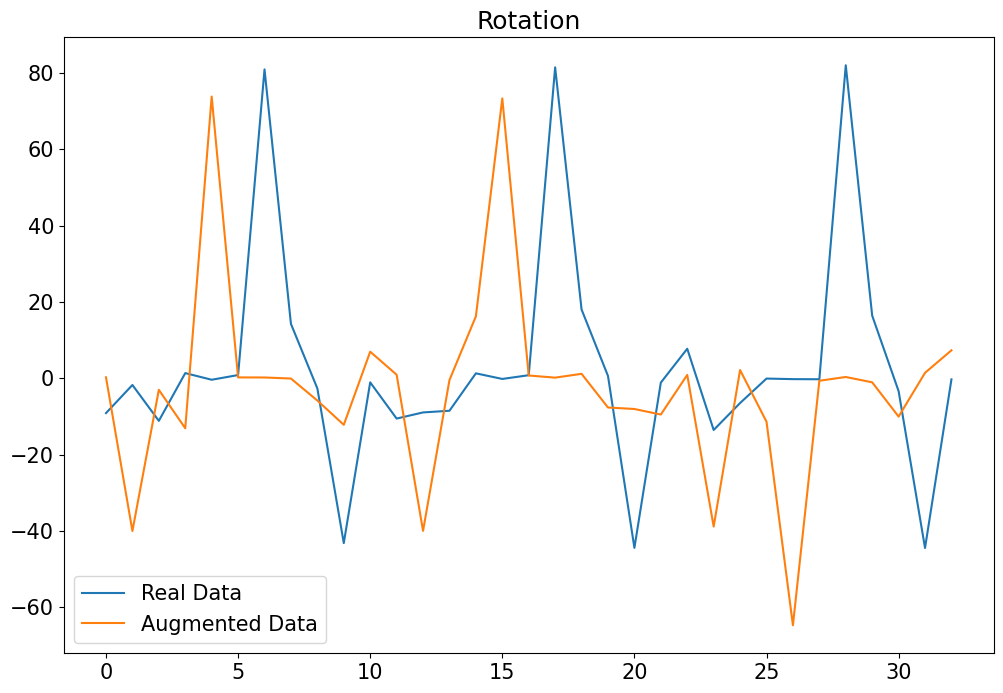

In [23]:
def rotation(input_seq):
  scale = np.random.choice([-0.8, 0.9], size=(input_seq.shape[0], input_seq.shape[1]))
  flipped_seq = torch.flip(input_seq, [0, 1])
  return np.multiply(flipped_seq, scale)

plt.plot(test_seq, label='Real Data')
plt.plot(rotation(test_seq), label='Augmented Data')
plt.title('Rotation')
plt.legend(loc='best')
plt.show()

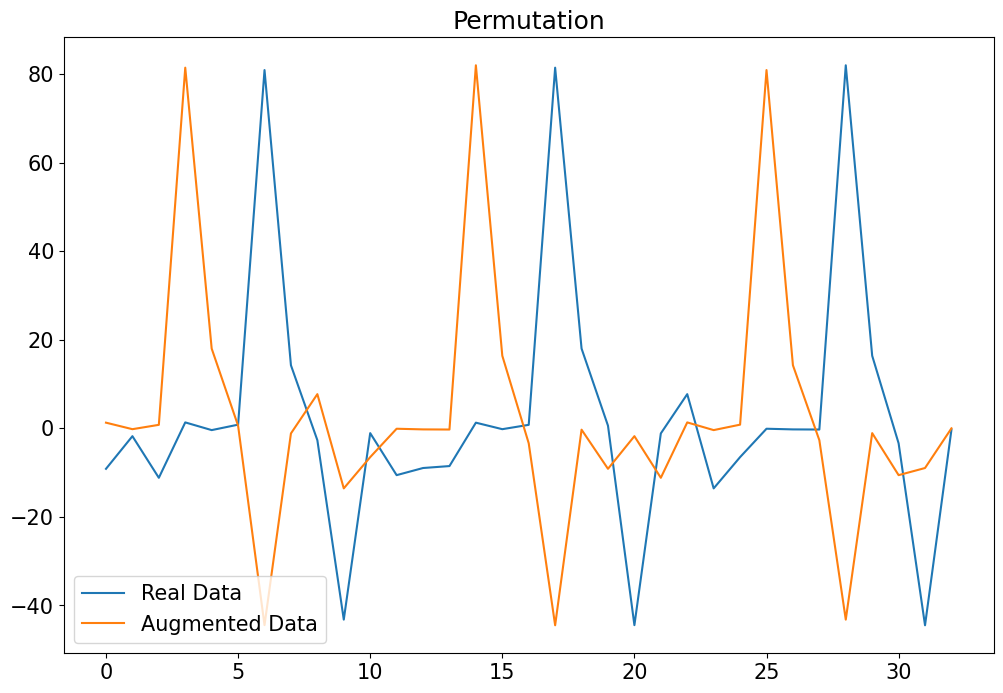

In [31]:
def permutation(input_seq):
  orig_steps = np.arange(input_seq.shape[0])

  num_segs = np.random.randint(2, 7)
  ret = np.zeros_like(input_seq)

  splits = np.array_split(orig_steps, num_segs)
  warp = np.concatenate(np.random.permutation(splits)).ravel()

  for i in range(input_seq.shape[0]-1):
    ret[i] = input_seq[warp[i]]
  
  return torch.tensor(ret).float()

plt.plot(test_seq, label='Real Data')
plt.plot(permutation(test_seq), label='Augmented Data')
plt.title('Permutation')
plt.legend(loc='best')
plt.show()

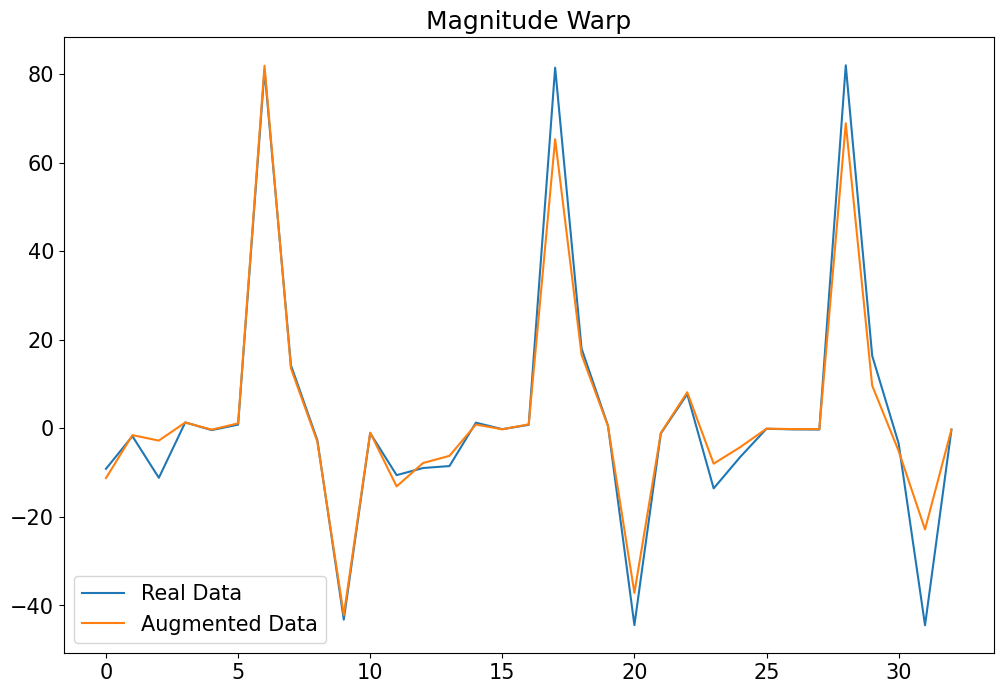

In [34]:
def magnitude_warp(input_seq, sigma=0.3):
  from scipy.interpolate import CubicSpline

  orig_steps = np.arange(input_seq.shape[0])
  random_warps = np.random.normal(loc=1.0, scale=sigma, size=(input_seq.shape[0], input_seq.shape[1]))
  warp_steps = (np.linspace(0, input_seq.shape[0], input_seq.shape[0])).T

  ret = np.zeros_like(input_seq)

  warper = CubicSpline(warp_steps, random_warps)(orig_steps)

  ret = np.multiply(test_seq, warper)

  return ret

plt.plot(test_seq, label='Real Data')
plt.plot(magnitude_warp(test_seq), label='Augmented Data')
plt.title('Magnitude Warp')
plt.legend(loc='best')
plt.show()

In [35]:
# Sequence augmentation using three random augmentation functions

import random

def sequence_augmentation(input_seq):
  ret = np.zeros_like(input_seq)
  aug_func_list = [jitter, scaling, rotation, permutation, magnitude_warp]

  aug_funcs = random.choices(aug_func_list, k=3)
  for func in aug_funcs:
    ret = func(input_seq)
  
  return ret

### Anomaly data augmentation

In [36]:
print('Anomaly set length before augmentation {0}'.format(len(test_anomaly_dataset)))

augmented_examples_count = len(test_normal_dataset) - len(test_anomaly_dataset)

for k in range(augmented_examples_count):
  true_anomaly = random.choice(test_anomaly_dataset[:441]) # random anomaly
  aug_anomaly = sequence_augmentation(true_anomaly)
  aug_anomaly = aug_anomaly.to(torch.float32)
  test_anomaly_dataset.append(aug_anomaly)

print('Anomaly set length after augmentation {0}'.format(len(test_anomaly_dataset)))

Anomaly set length before augmentation 441
Anomaly set length after augmentation 2198


### LSTM Autoencoder

In [37]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=8):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [38]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=8, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [39]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=8):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [40]:
model = RecurrentAutoencoder(seq_len, n_features, 16)
model = model.to(device)

### Training model

In [41]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [42]:
# 25 epochs -> train loss 180.47677663630532 val loss 183.84012266634377
# 50 epochs -> train loss 149.87340367753606 val loss 138.49130286623966
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=25
)

Epoch 1: train loss 173.0234485338102 val loss 173.830467045009
Epoch 2: train loss 170.13741249657676 val loss 163.0115274567667
Epoch 3: train loss 154.6819239316352 val loss 156.07975191807628
Epoch 4: train loss 147.51782297085404 val loss 148.47681180408404
Epoch 5: train loss 135.9457693313517 val loss 138.00253668130665
Epoch 6: train loss 143.84492511385054 val loss 137.36569093129157
Epoch 7: train loss 130.370772684344 val loss 127.11624571148403
Epoch 8: train loss 125.37187593886732 val loss 127.60817854639724
Epoch 9: train loss 124.75291262087049 val loss 124.86089302616371
Epoch 10: train loss 127.78743457859227 val loss 156.2758279284763
Epoch 11: train loss 138.76470264734857 val loss 128.42170825011084
Epoch 12: train loss 118.95442976629661 val loss 122.7225789447002
Epoch 13: train loss 114.37499762318518 val loss 116.02722418487153
Epoch 14: train loss 113.19190553817783 val loss 118.30980463405261
Epoch 15: train loss 109.76891202139676 val loss 139.655412034481
E

### Make a prediction

In [43]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

### Loading the model

In [44]:
# Loading the model
model = torch.load('model.pth')
model = model.to(device)

### Losses Distributions

In [45]:
test_predictions, test_losses = predict(model, test_normal_dataset)

Text(0.5, 1.0, 'Test Losses Distribution')

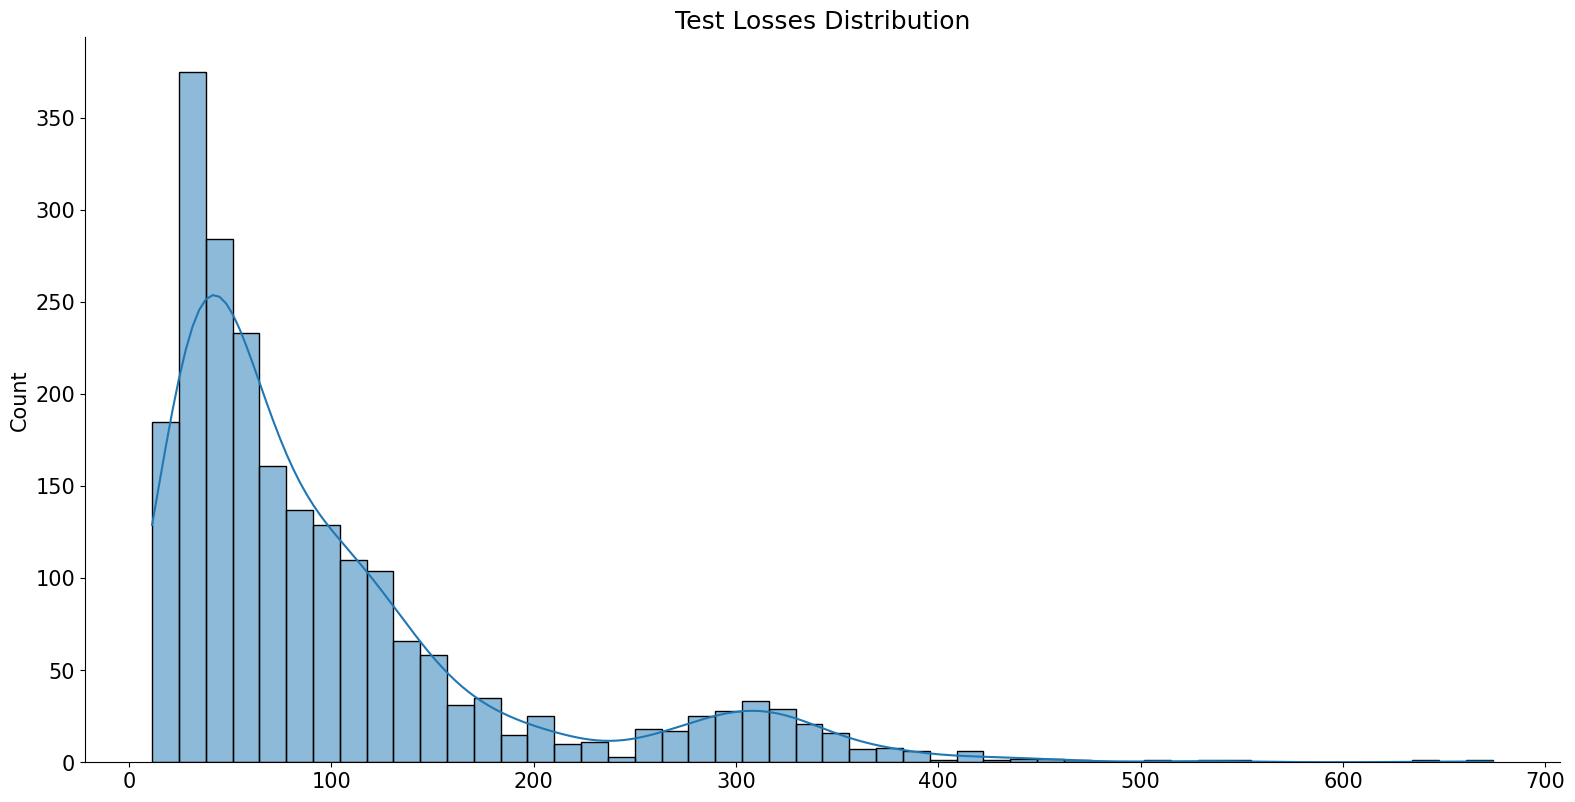

In [46]:
sns.displot(test_losses, bins=50, kde=True, height=8, aspect=2)
plt.title('Test Losses Distribution')

In [47]:
anomaly_predictions, anomaly_losses = predict(model, test_anomaly_dataset)

Text(0.5, 1.0, 'Anomaly Losses Distribution')

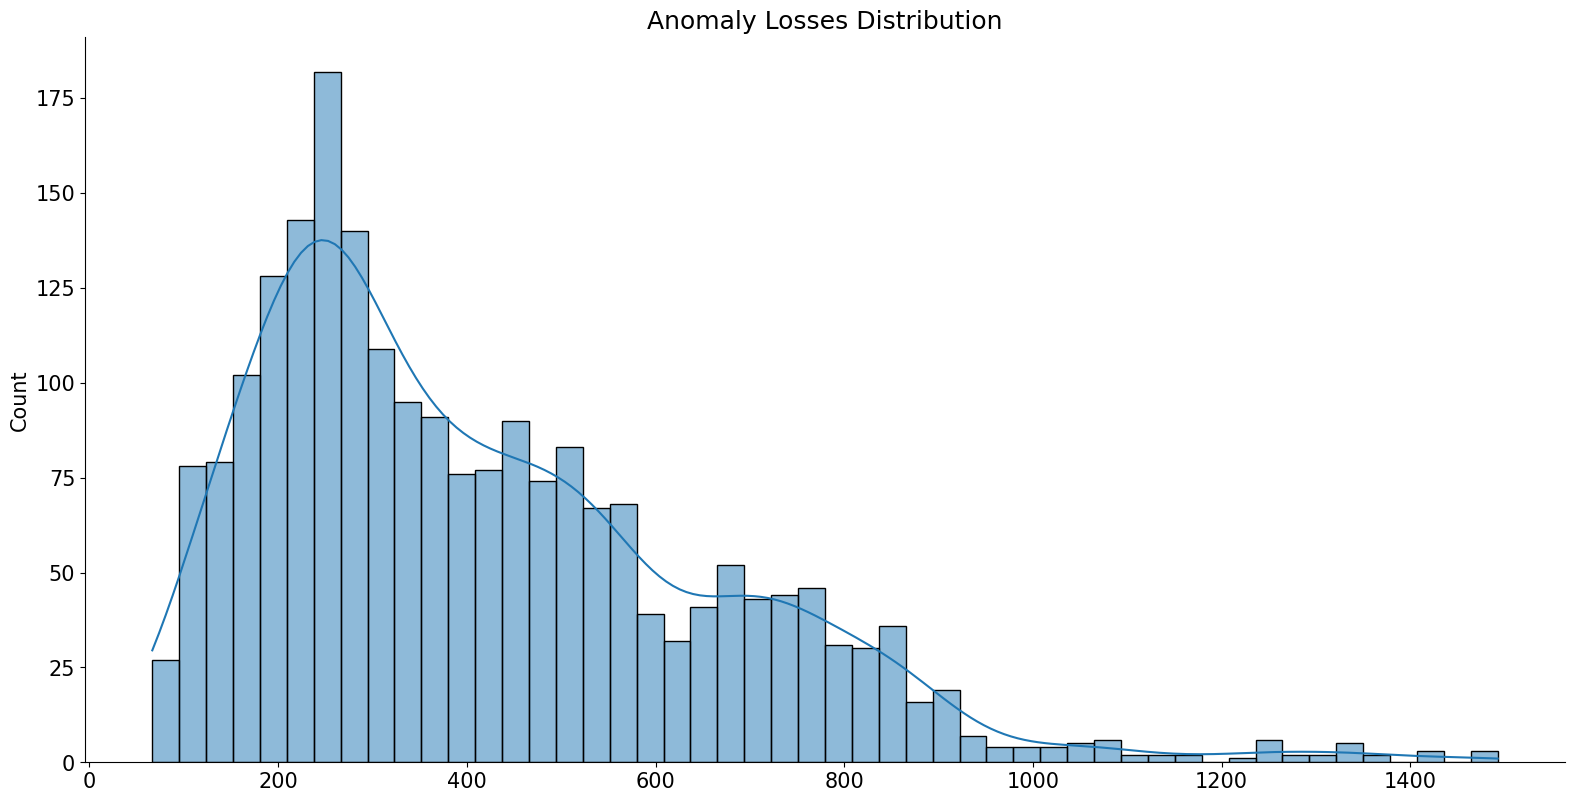

In [48]:
sns.displot(anomaly_losses, bins=50, kde=True, height=8, aspect=2)
plt.title('Anomaly Losses Distribution')

In [49]:
THRESHOLD = 175

In [52]:
correct = sum(loss <= THRESHOLD for loss in test_losses)
print(f'Correct normal predictions percantage: {correct / len(test_normal_dataset)}')

Correct normal predictions percantage: 0.8585077343039127


In [53]:
correct = sum(loss > THRESHOLD for loss in anomaly_losses)
print(f'Correct anomaly predictions percantage: {correct / len(test_anomaly_dataset)}')

Correct anomaly predictions percantage: 0.8798908098271155


### Examples

In [54]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

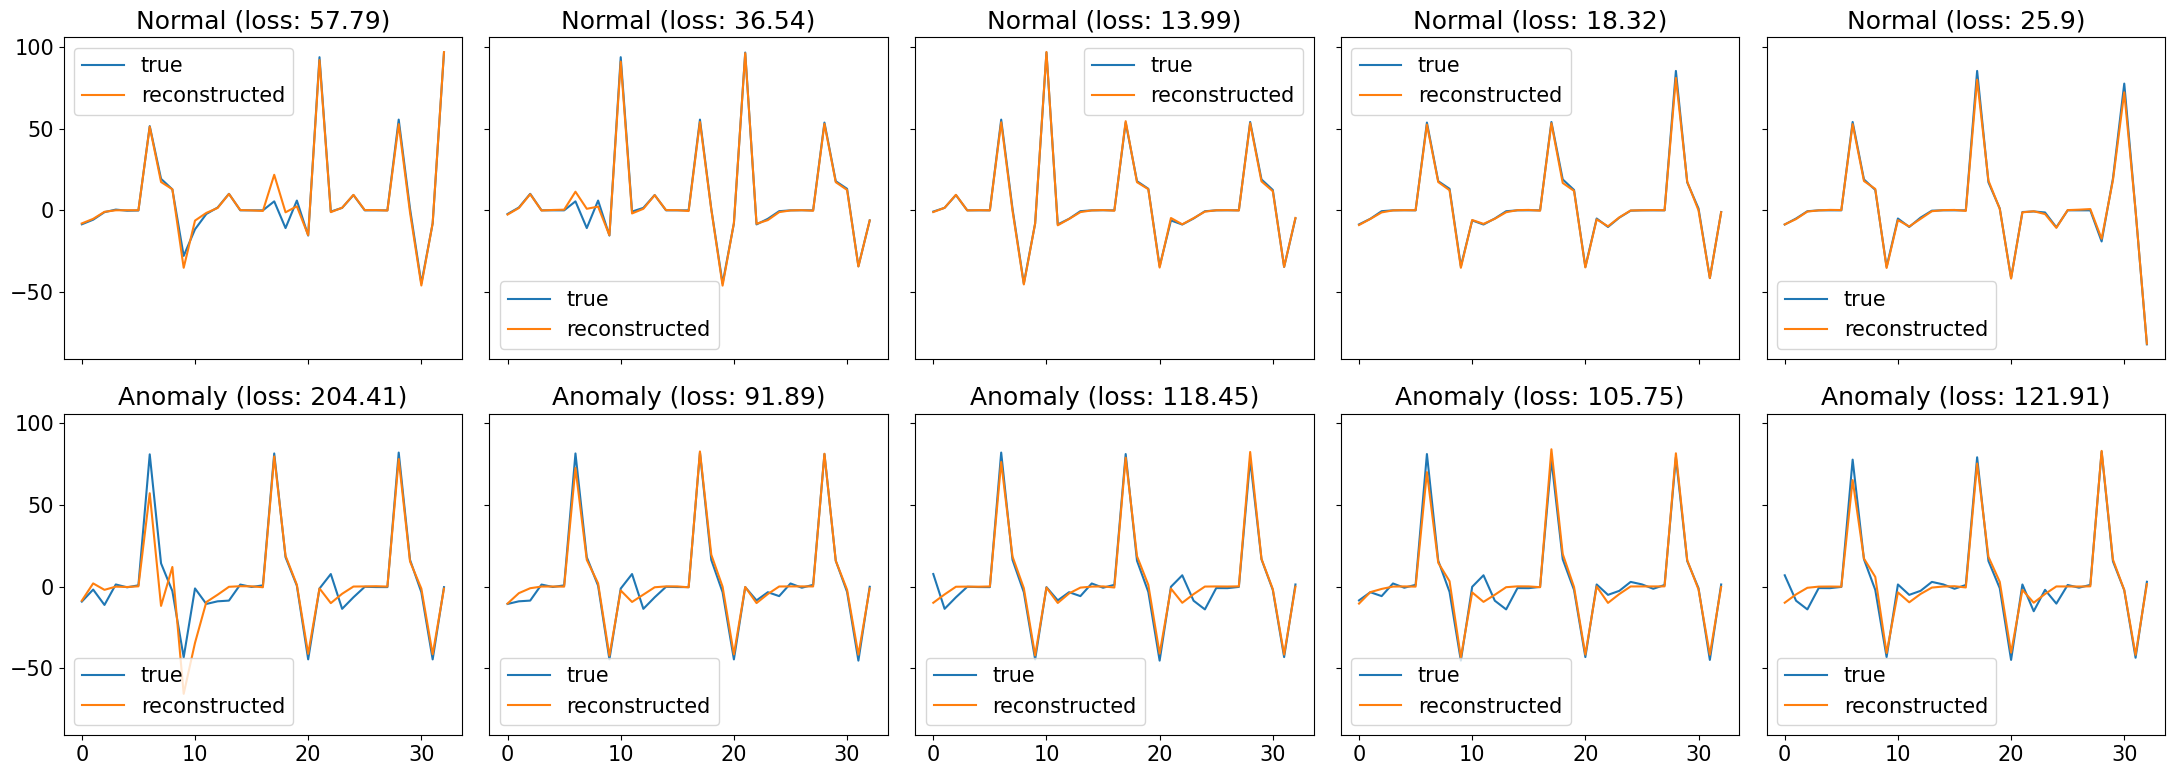

In [57]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=5,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:5]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:5]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

### Saving The Model

In [51]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)